# 07 - Building Embeddings

So far, we always performed the embedding lookup on a variable that is trained as we go.

This means that we are learning the embeddings every time we train.
A better option would be to pretrain our embeddings on a larger dataset and use this pretrained embedding in our final model.

We have two options:
1. use pretrained embeddings like Glove
2. train our own embeddings on our rap lyrics

We will first try to train our own embeddings, as rap might be a very specific type of text and general embeddings might not be applicable.

In [6]:
import os
import math
import glob
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

import tools.processing as pre

batch_size = 256
# embedding_dimension = 128
embedding_dimension = 10
negative_samples = 32
LOG_DIR = "logs/word2vec_intro"
EPOCHS = 20 

tf.reset_default_graph()

text = pre.get_text("data/final_2_pac_rakim_kid_cudi.txt")

sentences = []
sentences = [text.replace( "\n", ";" )]

# Map words to indices
word2index_map = {}
index = 0

print(sentences[0][:300])

vocab = pre.Vocabulary(sentences[0])

for sent in sentences:
    for word in sent.lower().split():
        if word not in word2index_map:
            word2index_map[word] = index
            index += 1
# index2word_map = {index: word for word, index in word2index_map.items()}
index2word_map = vocab.index2word
word2index_map = vocab._dict

vocabulary_size = len(index2word_map)

# Generate skip-gram pairs
skip_gram_pairs = []
for sent in sentences:
    tokenized_sent = sent.lower().split()
    for i in range(1, len(tokenized_sent)-1):
        word_context_pair = [[word2index_map[tokenized_sent[i-1]],
                              word2index_map[tokenized_sent[i+1]]],
                             word2index_map[tokenized_sent[i]]]
        skip_gram_pairs.append([word_context_pair[1],
                                word_context_pair[0][0]])
        skip_gram_pairs.append([word_context_pair[1],
                                word_context_pair[0][1]])

def get_skipgram_batch(batch_size):
    instance_indices = list(range(len(skip_gram_pairs)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    x = [skip_gram_pairs[i][0] for i in batch]
    y = [[skip_gram_pairs[i][1]] for i in batch]
    return x, y


# batch example
x_batch, y_batch = get_skipgram_batch(8)
x_batch
y_batch
[index2word_map[word] for word in x_batch]
[index2word_map[word[0]] for word in y_batch]

# Input data, labels
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# Embedding lookup table currently only implemented in CPU
with tf.name_scope("embeddings"):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_dimension],
                          -1.0, 1.0), name='embedding')
    # This is essentialy a lookup table
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Create variables for the NCE loss
nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_dimension],
                            stddev=1.0 / math.sqrt(embedding_dimension)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))


loss = tf.reduce_mean(
  tf.nn.nce_loss(weights=nce_weights, biases=nce_biases, inputs=embed, labels=train_labels,
                 num_sampled=negative_samples, num_classes=vocabulary_size))
tf.summary.scalar("NCE_loss", loss)

# Learning rate decay
global_step = tf.Variable(0, trainable=False)
learningRate = tf.train.exponential_decay(learning_rate=0.1,
                                          global_step=global_step,
                                          decay_steps=1000,
                                          decay_rate=0.95,
                                          staircase=True)
train_step = tf.train.GradientDescentOptimizer(learningRate).minimize(loss)
merged = tf.summary.merge_all()

TRAIN = True
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    train_writer = tf.summary.FileWriter(LOG_DIR,
                                         graph=tf.get_default_graph())

    with open(os.path.join(LOG_DIR, 'metadata.tsv'), "w") as metadata:
        metadata.write('Name\tClass\n')
        for k, v in index2word_map.items():
            metadata.write('%s\t%d\n' % (v, k))

    if glob.glob(LOG_DIR + '/*.meta'):
        TRAIN = False
        # global_step = sess.run(global_step)
        print("Restoring an old model and training it further..")
    else:
        print("Building model from scratch!")
        # global_step = 0

    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = embeddings.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(train_writer, config)

    if TRAIN:
        global_step = 0
        for epoch in range(EPOCHS):

            print(f"\n\nepoch: {epoch}\n")
            
            # epoch_steps = (int(len(skip_gram_pairs)/batch_size))
            epoch_steps = 1000
            for step in range(epoch_steps):
                x_batch, y_batch = get_skipgram_batch(batch_size)
                summary, _ = sess.run([merged, train_step],
                                    feed_dict={train_inputs: x_batch,
                                                train_labels: y_batch})
                train_writer.add_summary(summary, step + global_step)
                
                if step % 100 == 0:
                    loss_value = sess.run(loss,
                                            feed_dict={train_inputs: x_batch,
                                                        train_labels: y_batch})
                    print("Loss at %d/%d: %.5f" % (step, epoch_steps, loss_value))
            
            global_step += epoch_steps
                
    # Normalize embeddings before using
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    normalized_embeddings_matrix = sess.run(normalized_embeddings)

ref_word = normalized_embeddings_matrix[word2index_map["hate"]]

scantron ; aw ; surely ; shining ; something ; 88 ; trined ; right ; electric ; coasts ; coast ; togine ; marriage ; marriages ; 501 ; wizardry ; wizard ; wizard ; ay ; is ; ; ; yeah you know what this is nyc ; the triumphant return rakim allah ; rakim ; remember being introduced to rapping your fir
Restoring an old model and training it further..


### Now with our pretrained embeddings matrix, we can check how related the words are

In [9]:
def get_closest(word):
    ref_word = normalized_embeddings_matrix[word2index_map[word]]
    
    cosine_dists = np.dot(normalized_embeddings_matrix, ref_word)
    ff = np.argsort(cosine_dists)[::-1][0:10]
    for f in ff:
        print(index2word_map[f])
        print(cosine_dists[f])


In [10]:
get_closest("call")

call
0.9999999
harass
0.9296983
hard
0.8695386
sn
0.8633158
thrived
0.85187936
party
0.8187023
dillinger
0.8145992
torturing
0.8134195
isley
0.8116869
policemen
0.80563986


In [13]:
get_closest("death")

death
1.0
jet
0.882991
rings
0.87963736
slugger
0.8550251
handing
0.8443397
gain
0.8263931
office
0.82023484
especially
0.81402797
bunch
0.8116361
rode
0.8100765


In [15]:
get_closest("gun")

gun
1.0
embraced
0.93831253
eighty
0.928231
sticky
0.92747194
necks
0.9159136
responding
0.86556464
pratt
0.8601616
simultaneously
0.859185
individuals
0.8504395
lovers
0.85002613


In [16]:
get_closest("pistol")

pistol
1.0000001
experiment
0.9432442
hundred
0.9354329
rhymefumble
0.9113585
capacities
0.8776408
dominant
0.86174405
enter
0.8565933
conceited
0.85169804
gomars
0.84910536
quatro
0.83368963


### Not too bad, but also not too good :/
**gun** should be closer to **pistol** than the word experiment. This might be due too little data. Maybe some rapper prefer to use only the word **gun** while others only use **pistol**

This does not tell us anything about how closely related two words are if they are not used often enough

## Learnings
Let's check out Glove Embeddings instead!

### This is our embedding with the word "strangers"

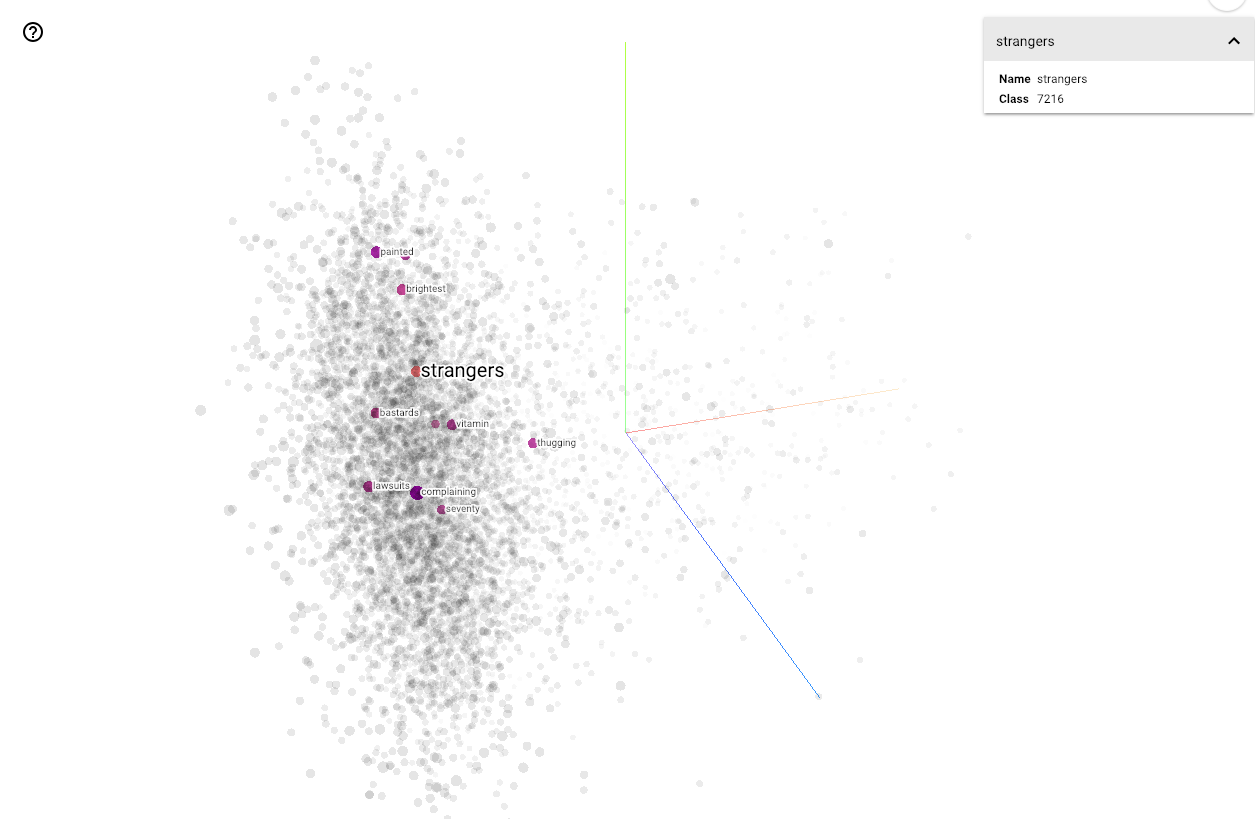